# Auxiliar 3 - CNN

Las redes convolucionales son un tipo de redes neuronales que se aplican principalmente a imágenes (redes convolucionales bidimensionales) y señales (redes convolucionales unidimensionales).

- Se utilizan filtros con pesos que se aplican en distintas zonas de la imagen.
- El valor obtenido de aplicar el filtro a cada parte de la imagen se transforma en un pixel de una nueva imagen de salida, a la cual se le puede aplicar una nueva capa convolucional.
- En las redes MLP los pesos eran fijos y por lo tanto las zonas de las imagenes que la red mira con mayor peso son fijas. Esto es un problema si los objetos pueden estar en distintas zonas de la imagen. Las redes convolucionales son invariantes a la traslación.

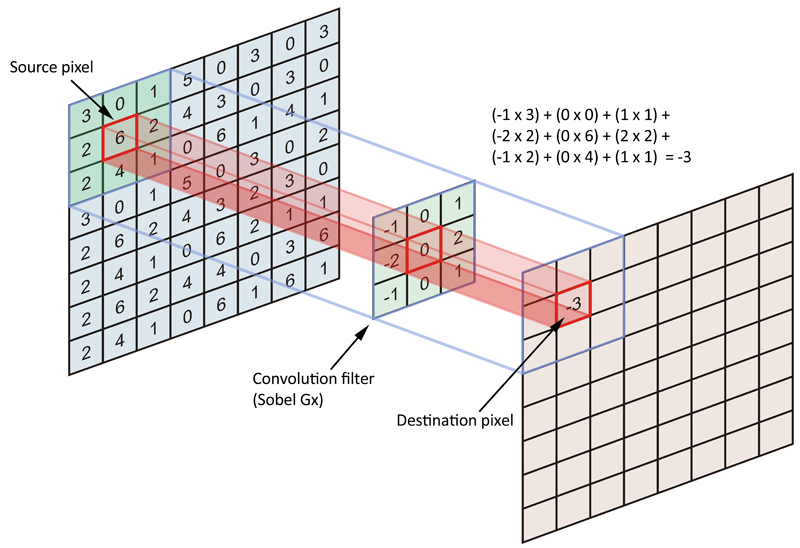

Imagen sacada del siguiente [link](https://towardsdatascience.com/deep-learning-personal-notes-part-1-lesson-3-cnn-theory-convolutional-filters-max-pooling-dbe68114848e)

Definición de funciones importantes e imports

In [38]:
import torch
from torch import nn
import torchvision

from matplotlib import pyplot as plt
import numpy as np
import time

## Definiendo una capa convolucional para imágenes de un canal

Primero cargamos datos de MNIST, los que están en escala de grises (un canal).

In [40]:
mnist_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),                          # Converts images to PyTorch tensors
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

mnist_dataset = torchvision.datasets.MNIST(
    root="./mnist",
    train=True,
    download=True,
    transform=mnist_transform,
)

Definimos nuestra capa convolucional bidimensional entregando los siguientes parámetros:

- in_channels: Estos son los canales de entrada. Para una imagen RGB se tienen 3 canales (red, green y blue). Para una imagen en escala de grises se tiene un solo canal.
- out_channels: Esto corresponde a cuantos canales de salida se quieren. La idea es que se pueda aplicar más de un filtro a la imagen y dado que cada filtro genera un canal de salida, entonces el número de canales de salida es equivalente al número de filtros que se crearán.
- kernel_size: Como su nombre lo dice, este parámetro es el tamaño del kernel del filtro. Si se entrega un solo valor entero N, entonces se usa un filtro de tamaño NxN. Sino, se puede entregar una tupla. Los pesos del kernel por defecto se inicializan con valores aleatorios usando una distribución uniforme o normal.

In [41]:
conv_layer = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)

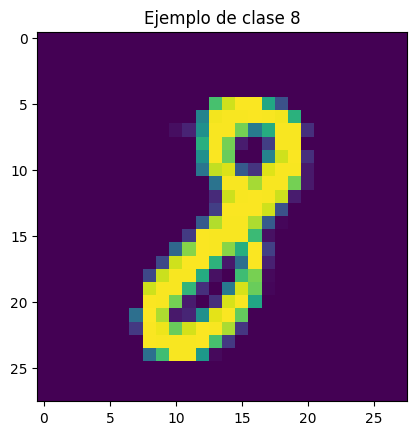

In [48]:
example_image, example_class = mnist_dataset[np.random.randint(len(mnist_dataset))]

plt.imshow(example_image.squeeze())
plt.title(f"Ejemplo de clase {example_class}")
plt.show()

In [49]:
output_image = conv_layer(example_image)
print(f"Input image shape: {example_image.shape}")
print(f"Output image shape: {output_image.shape}")

Input image shape: torch.Size([1, 28, 28])
Output image shape: torch.Size([10, 26, 26])


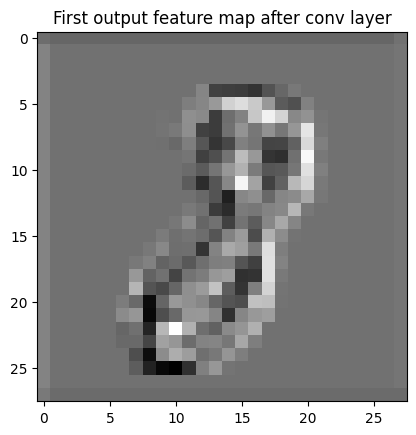

In [56]:
plt.imshow(output_image[0].detach().numpy(), cmap='gray')
plt.title("First output feature map after conv layer")
plt.show()

¿Por qué la convolución redujo el número de pixeles?. Naturalmente si se utilizan filtros de más de 1x1 pixeles, entonces va a haber una reducción en el número de pixeles ya que el filtro no puede ser pasado con su centro en cada pixel de la imagen. Esto puede cambiarse con los siguientes parámetros:

- stride: El stride de una capa corresponde al número de pixeles que se mueve el filtro para realizar la siguiente evaluación. Por defecto es 1.
- padding: El padding de una capa corresponde al número de pixeles agregados a los bordes de la imagen antes de aplicar los filtros. Estos pixeles pueden ser de distintos tipos, los cuales se configuran con el argumento `padding_mode`.
- padding_mode: El modo de padding utilizado:
    - zeros: Se usan sólo ceros en los bordes agregados.
    - reflect: El padding se genera reflejando los pixeles, es decir, se repiten los pixeles en orden contrario.
    - replicate: El padding se genera copiando el valor del borde.
    - circular

Los argumentos anteriores en conjunto con el tamaño del kernel determinan el tamaño final de la imagen con las siguientes fórmulas:

Formula Simplificada:
\begin{align}
\text{Output size} = \frac{\text{Input size} - \text{Kernel size} + 2 \times \text{Padding}}{\text{Stride}} + 1
\end{align}



Formula General:

\begin{align}
    H_{out} &= \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
                        \times (\text{kernel_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor \\
W_{out} &= \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
                        \times (\text{kernel_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor
\end{align}

Donde dilation es otro argumento que no veremos por el momento.

IMPORTANTE: No es necesario aprenderse estas fórmulas de memoria, sólo sepan que existen y que pueden encontrarlas. Además puede servirles deducirlas ustedes mismos.

In [53]:
# Si ahora agregamos padding = 1, obtenemos el mismo tamaño de la imagen de entrada. Esto funciona en este caso porque el filtro es de tamaño 3x3 y el stride es 1.
conv_layer = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=1)

output_image = conv_layer(example_image)
print(f"Input image shape: {example_image.shape}")
print(f"Output image shape: {output_image.shape}")

Input image shape: torch.Size([1, 28, 28])
Output image shape: torch.Size([10, 28, 28])


Hay que tener algunas consideraciones al utilizar padding:

El padding son efectivamente datos falsos ya que son agregados por el usuario sin una justificación de parte de la distribución de los datos. Por lo anterior, si aplican padding, háganlo con cuidado. El zero padding por ejemplo es un cambio brusco en la imagen, esto puede afectar la clasificación, ya que la evaluación de los filtros en los bordes va a tener menos pixeles con valores distintos de cero y por lo tanto claramente esto afectará los bordes de la imagen de salida.


Finalmente visualicemos algunos filtros.

In [54]:
filters = conv_layer.weight.detach().numpy()

print(f"Los filtros tienen forma: {filters.shape}")

Los filtros tienen forma: (10, 1, 3, 3)


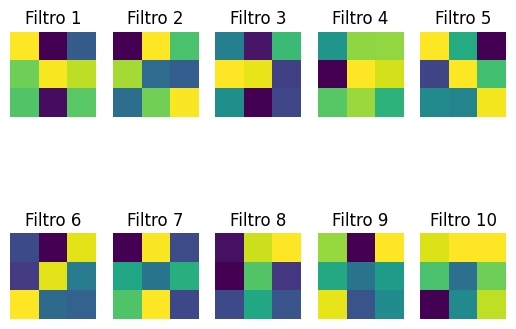

In [55]:
fig, axes = plt.subplots(2, 5)

for i in range(filters.shape[0]):
    ax = axes.flat[i]
    ax.imshow(filters[i, 0, ...])
    ax.axis("off")
    ax.set_title(f"Filtro {i + 1}")

plt.show()

## Definiendo una capa convolucional para imágenes de múltiples canales

Ahora cargamos el dataset CIFAR10 que contiene imágenes a color (3 canales).

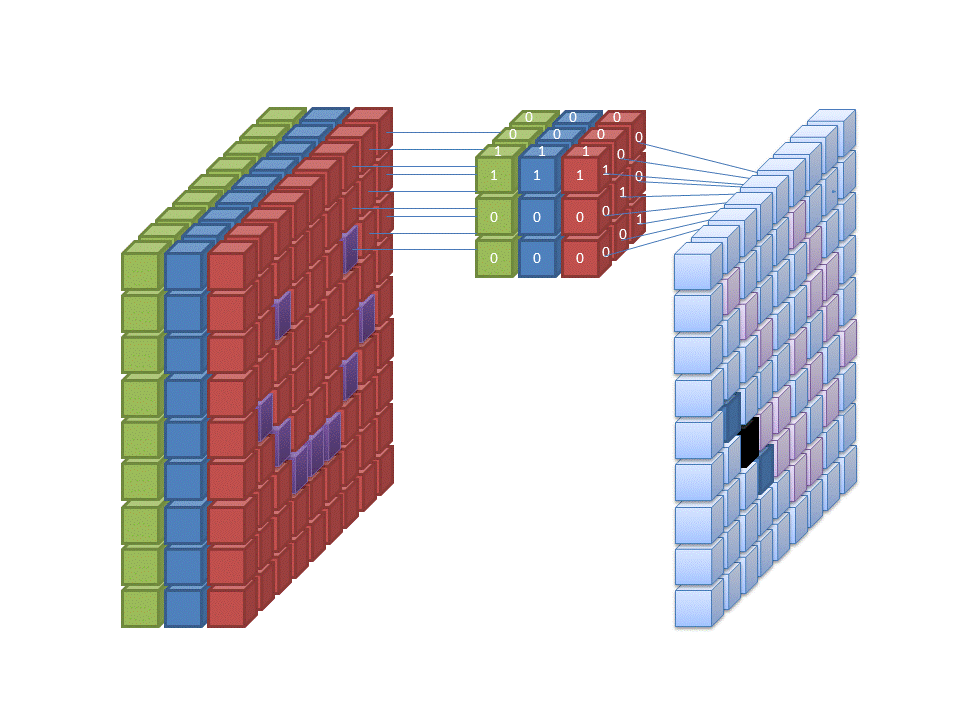

In [13]:
cifar_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=cifar_transform,
)

classes = train_cifar10.classes

100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


In [57]:
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


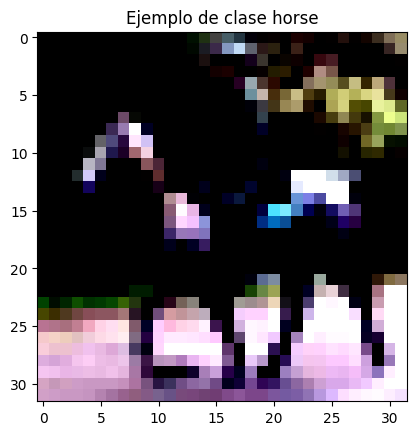

In [67]:
example_image, example_class = train_cifar10[np.random.randint(len(train_cifar10))]

plt.imshow(example_image.permute(1, 2, 0))
plt.title(f"Ejemplo de clase {classes[example_class]}")
plt.show()

In [68]:
# IMPORTANTE: ahora in_channels = 3
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)

output_image = conv_layer(example_image)
print(f"Input image shape: {example_image.shape}")
print(f"Output image shape: {output_image.shape}")

Input image shape: torch.Size([3, 32, 32])
Output image shape: torch.Size([10, 28, 28])


In [69]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding=2)

output_image = conv_layer(example_image)
print(f"Input image shape: {example_image.shape}")
print(f"Output image shape: {output_image.shape}")

Input image shape: torch.Size([3, 32, 32])
Output image shape: torch.Size([10, 32, 32])


In [70]:
filters = conv_layer.weight.detach().numpy()

print(f"Los filtros tienen forma: {filters.shape}")

Los filtros tienen forma: (10, 3, 5, 5)


Ahora juntaremos dos capas convolucionales

In [71]:
simple_conv_net = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3)
)

print("Network:")
print(simple_conv_net)

print()

output_image = simple_conv_net(example_image)
print(f"Input image shape: {example_image.shape}")
print(f"Output image shape: {output_image.shape}")

Network:
Sequential(
  (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
)

Input image shape: torch.Size([3, 32, 32])
Output image shape: torch.Size([16, 28, 28])


## Capas de pooling

Las capas de pooling funcionan de manera similar a las capas convolucionales en el sentido que utilizan parches para mirar distintas partes de una imagen, pero la diferencia está en las operaciones realizadas.

Una capa convolucional normal multiplica los pesos del filtro por los valores de los pixeles de la imagen, mientras que la capa de pooling aplica operaciones que no involucran pesos. Las más utilizadas son:

- Max pooling: Esta capa entrega como resultado el valor máximo de los pixeles que ve el filtro en cada operación.
- Average pooling: A diferencia de max pooling, esta capa entrega el promedio.


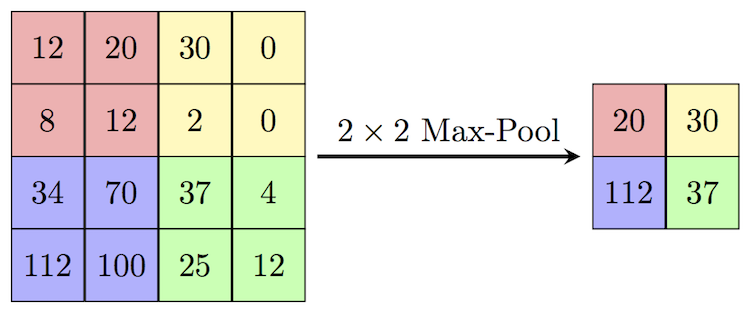

Estas capas permiten realizar un downsampling de los feature maps intermedios, permitiendo reducir el número de parámetros, lograr aplicar los filtros siguientes a una escala distinta, entregar una leve invarianza extra a la traslación, etc.

En pytorch estas capas se definen con:

```
nn.MaxPool2d(kernel_size=2)
```

Donde kernel_size es el tamaño del filtro sobre el cual se aplica el máximo. Un kernel size de 2 con un stride de 2 reduce el alto y el ancho de la imagen a la mitad.

## Extra: Dropout

Dropout es una técnica de regularización que permite apagar ciertas neuronas en el entrenamiento de forma aleatoria. Dropout se desactiva en test, por lo que si bien al entrenar no se usan todas las neuronas, en test si se utilizan todas.

La razón principal por la que funciona dropout es que si la red bloquea una neurona mala, entonces se está ayudando a predecir mejor, por el contrario, si la red bloquea una neurona buena, entonces se está enseñando a las otras neuronas a aprender una buena representación de los datos.

En torch la capa de dropout se define como:

```
nn.Dropout(p=0.2)
```

Donde p es la probabilidad de apagar una neurona.

IMPORTANTE: siempre lean la documentación para ver qué significa p, ya que en otros frameworks p es la probabilidad de mantener una neurona encendida.

Hasta ahora pueden haberse preguntado para qué sirven las instrucciones

```
model.train()
model.eval()
```

Estas instrucciones le permiten al modelo saber qué está haciendo para cambiar su comportamiento respectivamente. En el caso de dropout, si ustedes no utilizan esto, entonces el modelo siempre va a estar en su modo inicial y va a mantenerlo tanto en evaluación como en entrenamiento.

Recuerden siempre utilizar estas instrucciones ya que un clásico error es mantener dropout encendido en test y obtener peores resultados de los que deberían.

## Entrenando una red convolucional para MNIST

A continuación creamos y entrenamos una red convolucional para clasificar MNIST.

In [72]:
train_mnist, val_mnist = torch.utils.data.random_split(mnist_dataset, [50000, 10000])

example_to_show1, class_to_show1 = val_mnist[0]
example_to_show2, class_to_show2 = val_mnist[1]

In [73]:
def show_filters(model, x, y):

    out = model.block2[0](model.block1(example_to_show2.unsqueeze(0)))[0].detach().numpy()
    # out = model.block1(example_to_show.unsqueeze(0))[0].detach().numpy()

    fig, axes = plt.subplots(4, 4, figsize=(5, 6))
    fig.suptitle(f"Class {class_to_show2}")

    for i in range(16):
        ax = axes.flat[i]
        ax.imshow(out[i])
        ax.axis("off")
        ax.set_title(f"Canal {i + 1}")

    plt.show()

In [74]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=False,
    show_filters_action=False
):
    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": []
    }

    t0 = time.perf_counter()

    iteration = 0

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            # Predicción
            y_predicted = model(x_batch)

            # Cálculo de loss
            loss = criterion(y_predicted, y_batch)

            # Actualización de parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()

            cumulative_train_corrects += (y_batch == class_prediction).sum()

            if (iteration in [0, 25, 100] or (epoch == epochs - 1)) and show_filters_action:
                show_filters(model, x_batch, y_batch)

            if iteration % 100 == 0:
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                # Evaluación del modelo
                model.eval()
                x_val, y_val = next(iter(val_loader))
                if use_gpu:
                    x_val = x_val.cuda()
                    y_val = y_val.cuda()

                y_predicted = model(x_val)

                loss = criterion(y_predicted, y_val)

                class_prediction = torch.argmax(y_predicted, axis=1).long()
                val_acc = (y_val == class_prediction).sum() / y_val.shape[0]
                val_loss = loss.item()

                curves["train_acc"].append(train_acc.item())
                curves["val_acc"].append(val_acc.item())
                curves["train_loss"].append(train_loss)
                curves["val_loss"].append(val_loss)

                print(f"Itearation {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}")

                cumulative_train_loss = 0
                cumulative_train_corrects = 0
                train_loss_count = 0
                train_acc_count = 0

            iteration += 1

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    return curves

In [31]:
class CNNModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.mlp = nn.Sequential(
            nn.Flatten(),

            nn.Linear(400, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, n_classes)
        )

        self.net = nn.Sequential(
            self.block1,
            self.block2,
            self.mlp
        )

    def forward(self, x):
        return self.net(x)

In [75]:
model = CNNModel(n_classes=10)
print(model)
print(model(example_to_show2.unsqueeze(0)).shape)

CNNModel(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mlp): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [ ]:
epochs = 10
batch_size = 64
lr = 5e-4
criterion = nn.CrossEntropyLoss()

model = CNNModel(n_classes=10)

curves = train_model(
    model,
    train_mnist,
    val_mnist,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    show_filters_action = False
)

Epoch 1/10
Itearation 0 - Batch 0/782 - Train loss: 2.3053221702575684, Train acc: 0.125, Val loss: 2.299762010574341, Val acc: 0.09919999539852142
Itearation 100 - Batch 100/782 - Train loss: 1.0961498376727103, Train acc: 0.6953125, Val loss: 0.42774033546447754, Val acc: 0.8732999563217163
Itearation 200 - Batch 200/782 - Train loss: 0.33265979200601575, Train acc: 0.90234375, Val loss: 0.2571660876274109, Val acc: 0.9225999712944031
Itearation 300 - Batch 300/782 - Train loss: 0.24514822244644166, Train acc: 0.9254687428474426, Val loss: 0.18211209774017334, Val acc: 0.9465000033378601
Itearation 400 - Batch 400/782 - Train loss: 0.18310947827994822, Train acc: 0.94593745470047, Val loss: 0.14410457015037537, Val acc: 0.9581999778747559
Itearation 500 - Batch 500/782 - Train loss: 0.15052613064646722, Train acc: 0.9562499523162842, Val loss: 0.12181626260280609, Val acc: 0.9639999866485596
Itearation 600 - Batch 600/782 - Train loss: 0.11645582303404808, Train acc: 0.96578121185302

**Recordatorio**:

**Batch** refiere a un subet de datos siendo procesado.

**Iteration** refiere a cada vez que el modelo procesa un batch y actualiza los parametros.

**Epoch** es un paso completo por todos los datos.

## Capas convolucionales unidimensionales

Las imágenes pueden ser interpretadas como señales bidimensionales, ya que se tiene un alto y un ancho, es decir, dos dimensiones para los valores de la señal. Como pudieron ver, para las imágenes utilizamos la clase:

```
nn.Conv2d()
```

Sin embargo, las señales unidimensionales igual pueden ser procesadas con redes convolucionales. Para esto existe:

```
nn.Conv1d()
```

El funcionamiento es equivalente, lo veremos a continuación.

In [ ]:
# Creamos una señal de un canal y 100 steps en el tiempo
input_signal = torch.randn(1, 100)

plt.plot(input_signal.squeeze())

In [ ]:
conv1d_layer = nn.Conv1d(in_channels=1, out_channels=10, kernel_size=5)

output_signal = conv1d_layer(input_signal)
print(f"Input signal shape: {input_signal.shape}")
print(f"Output signal shape: {output_signal.shape}")

Los filtros en estas capas permiten procesar las señales considerando los elementos anteriores y posteriores al elemento que se está mirando en cada momento, es decir, se puede considerar un contexto al momento de procesar.

De forma similar a las imágenes, al procesar señales se obtiene a la salida varios canales de señales.